In [1]:
import pandas as pd
import numpy as np
from time import time

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
from math import pi

from omterms.interface import *

## Plots and Prints

In [2]:
categories=['universalism', 'hedonism', 'achievement', 'power',
       'self-direction', 'benevolence', 'conformity', 'tradition', 'stimulation',
       'security']

def plot_radar_chart(doc_topic_cumul, doc):
    # ------- PART 1: Create background
 
    # number of variablecategories
    schwartz =['universalism', 'benevolence', 'conformity', 'tradition',
       'security', 'power', 'achievement', 'hedonism', 'stimulation',
       'self-direction']
    
    schwartz_dist = []
    for sch in schwartz:
        schwartz_dist.append(doc_topic_cumul[doc][categories.index(sch)])
    
    N = len(schwartz)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8,8))
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], schwartz)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([25,50,75], ["25","50","75"], color="grey", size=7)
    plt.ylim(0,100)


    # ------- PART 2: Add plots

    # Plot each individual = each line of the data
    # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

    # Ind1
    values = list(schwartz_dist) + list(schwartz_dist[:1])
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'b', alpha=0.1)

    # Add legend
    #plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Schwartz Chart - Doc " + str(doc))
    plt.show()
    
    
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
def print_top_words(model, tfidf_vectorizer, n_top_words, n_topics=3):
    feature_names = tfidf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        if topic_idx % n_topics == 0:
            try:
                print(color.CYAN + color.BOLD + categories[topic_idx//3] + color.END)
            except:
                print(color.CYAN + color.BOLD + "General" + color.END)
        message = color.BOLD + "Topic #%d: " % topic_idx + color.END
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        if (topic_idx+1) % n_topics == 0:
            print()
    print()
    
def print_cumulative_train_doc_topics(data, doc_topic, doc, n_best):
    test_theme = data.iloc[doc]['theme']
    print(color.BOLD + "Doc " + str(doc) + color.RED +  " (" + test_theme + ")\t: " + color.END, end='')
    dt = doc_topic[doc]
    for i in dt.argsort()[:-n_best - 1:-1]:
        print("(", end='')
        try:
            print(color.CYAN + color.BOLD + categories[i] + color.END, end='')
        except:
            print(color.CYAN + color.BOLD + "General" + color.END, end='')
        print(", %d, %.2lf)  " %(i, dt[i]), end='')    
    print()
    
def print_cumulative_test_doc_topics(doc_topic, doc, n_best):
    print(color.BOLD + "Doc " + str(doc) + "\t: " + color.END, end='')
    dt = doc_topic[doc]
    for i in dt.argsort()[:-n_best - 1:-1]:
        print("(", end='')
        try:
            print(color.CYAN + color.BOLD + categories[i] + color.END, end='')
        except:
            print(color.CYAN + color.BOLD + "General" + color.END, end='')
        print(", %d, %.2lf)  " %(i, dt[i]), end='')    
    print()

def print_doc_topics(doc_topic, doc, n_best):
    print(color.BOLD + "Doc " + str(doc) + "\t: " + color.END, end='')
    for i in doc_topic[doc].argsort()[:-n_best - 1:-1]:
        print("(", end='')
        try:
            print(color.CYAN + color.BOLD + categories[i//3] + color.END, end='')
        except:
            print(color.CYAN + color.BOLD + "General" + color.END, end='')
        print(", %d, %.2lf)  " %(i, doc_topic[doc][i]), end='')    
    print()

## Helper Functions

In [51]:
def build_W(N, n_topics, n_themes, theme_counts):
    rands = np.random.random( N * n_topics * (n_themes+1))
    W = np.zeros((N, n_topics * n_themes))

    cum_doc_count = 0
    idx = 0
    for theme, doc_count in theme_counts.items():
        #print("Theme: " + str(theme) + " Doc_count: " + str(doc_count))
        start = cum_doc_count
        end = start + doc_count
        W[start:end, idx*n_topics:(idx+1)*n_topics] = rands[:(end-start)*n_topics].reshape((end-start, n_topics))
        listrands = list(rands)
        del listrands[:(end-start)*n_topics]
        rands = np.array(listrands)
        
        cum_doc_count += doc_count
        idx +=1

    last_column = rands[- N * n_topics:].reshape((N, n_topics))
    
    return np.column_stack((W, last_column))

def cumulate_W(W, n_topics):
    W_cumul = []
    for d in W:
        temp = []
        for i in range(W.shape[1]//n_topics):
            temp.append(d[i*n_topics:(i+1)*n_topics].sum())
        W_cumul.append(temp)

    W_cumul = np.asarray(W_cumul)
    
    return W_cumul

def normalize_W(W):
    W_cumul_norm = W/(W.sum(axis=1).reshape(W.shape[0], 1))
    W_cumul_norm *= 100
    
    return W_cumul_norm

def export_to_excel(W, filepath):
    '''
    Take cumulated W as input.
    Don't forget to put xlsx as file extension '''
    
    df = pd.DataFrame(data=W,index = range(len(W)), columns=categories+['general'])
    df.to_excel(filepath)
    return df

def export_to_csv(W, filepath):
    '''
    Take cumulated W as input.
    Don't forget to put csv as file extension '''
    
    df = pd.DataFrame(data=W,index = range(len(W)), columns=categories+['general'])
    df.to_csv(filepath)
    return df

## Main Functions

In [4]:
def read_data(filepath):
    data = pd.read_json(filepath)
    data = data[data['text']!=""]
    data = data.sort_values('theme.id')
    
    return data
    
def extract_corpus(data):    
    corpus = list(data['text'])
    return corpus

def preprocess_corpus(corpus):
    PPcorpus = [' '.join(list((extract_terms(doc, extra_process = ['stem'])['Stem']+' ')*extract_terms(doc, extra_process = ['stem'])['TF'])) for doc in corpus]
    return PPcorpus

def train_corpus(corpus, data, n_topics=3, betaloss = 'kullback-leibler'):
    N = len(data)
    
    theme_counts = data.groupby(['theme.id','theme']).count().iloc[:,1]
    pd_theme_counts = pd.DataFrame(theme_counts)
    n_themes = len(theme_counts)
    
    n_top_words = 5
    n_components = n_topics*(n_themes)
    
    
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer() # optionally add maxfeatures = n_features to enforce number of features
    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(corpus)
    n_features = tfidf.shape[1]
    print("done in %0.2fs." % (time() - t0))
    
    X = tfidf 
    W = build_W(N, n_topics, n_themes, theme_counts)
    H = np.random.rand(n_components+n_topics, n_features)
    
    # Fit the NMF model
    print("Fitting the NMF model (" + betaloss + ") with tf-idf features, "
          "n_samples=%d and n_features=%d..."
          % (N, n_features))
    t0 = time()

    nmf = NMF(n_components= n_components+n_topics, solver='mu', beta_loss=betaloss,
              alpha=.1, l1_ratio=.5, init = 'custom')

    nmf.fit_transform(X=X,W=W,H=H)
    print("done in %0.2fs." % (time() - t0))
    
    return nmf, W, tfidf, tfidf_vectorizer
    
def evaluate_docs(docs, nmf, tfidf_vectorizer, betaloss = 'kullback-leibler'):
    print("Extracting tf-idf features for NMF...")
    t0 = time()
    tfidf_test = tfidf_vectorizer.transform(docs)
    #tfidf = tfidf_vectorizer.transform(corpusX)
    n_features = tfidf_test.shape[1]
    print("done in %0.2fs." % (time() - t0))
    
    X_test = tfidf_test
    H_test = nmf.components_
    
    
    # Fit the NMF model
    print("Fitting the NMF model (" + betaloss + ") with tf-idf features, ")
    t0 = time()

    W_test = nmf.transform(X_test)
    print("done in %0.2fs." % (time() - t0))
    
    return W_test, tfidf_test

## Training Model

In [ ]:
#https://github.com/bulentozel/OpenMaker/blob/master/Semantics/data/corpuses/schwartz.json
filepath = 'schwartz.json'

data = read_data(filepath)
corpus = extract_corpus(data)
corpus = preprocess_corpus(corpus)

In [6]:
nmf, W_train, tfidf_train, tfidf_vectorizer = train_corpus(corpus, data, n_topics=3, betaloss = 'kullback-leibler')

Extracting tf-idf features for NMF...
done in 0.77s.
Fitting the NMF model (kullback-leibler) with tf-idf features, n_samples=494 and n_features=36464...
done in 24.62s.


In [7]:
print("\nTopics in NMF model:")
print_top_words(nmf, tfidf_vectorizer, n_top_words=5, n_topics=3)


Topics in NMF model:
universalism
Topic #0: explor english spoke mandatori crew
Topic #1: disarma law found good effect
Topic #2: organ spirit speech system number

hedonism
Topic #3: outrag use indian western sever
Topic #4: self see time pleasur piti
Topic #5: surpris self jealousi remov peopl

achievement
Topic #6: interest greater use three offer
Topic #7: set suggest term platform time
Topic #8: mean recent return properti machin

power
Topic #9: articl wangchuck option method secular
Topic #10: use part troubl moham valu
Topic #11: highli compos technic toxic bia

self-direction
Topic #12: project gener photographi ilinx valuabl
Topic #13: benedek secess liberti sever train
Topic #14: non burkina carrol domin muslim

benevolence
Topic #15: seek siqe told user automat
Topic #16: valu map major polici surcharg
Topic #17: look life shown isaac discrimin

conformity
Topic #18: two ms supremaci parent businessmen
Topic #19: similar moral especi day underli
Topic #20: great sanford we

Distribution over sub-topics.

In [8]:
res = [print_doc_topics(W_train, idx, 4) for idx,row in enumerate(W_train)]

Doc 0	: (General, 30, 0.06)  (General, 32, 0.00)  (General, 31, 0.00)  (universalism, 1, 0.00)  
Doc 1	: (universalism, 2, 0.04)  (universalism, 1, 0.01)  (General, 31, 0.01)  (General, 32, 0.01)  
Doc 2	: (universalism, 1, 0.03)  (General, 32, 0.01)  (General, 31, 0.01)  (General, 30, 0.00)  
Doc 3	: (universalism, 1, 0.05)  (General, 31, 0.01)  (universalism, 0, 0.00)  (General, 30, 0.00)  
Doc 4	: (General, 31, 0.04)  (General, 30, 0.00)  (universalism, 2, 0.00)  (universalism, 1, 0.00)  
Doc 5	: (universalism, 0, 0.04)  (General, 31, 0.00)  (universalism, 1, 0.00)  (universalism, 2, 0.00)  
Doc 6	: (universalism, 0, 0.06)  (General, 30, 0.01)  (General, 32, 0.00)  (General, 31, 0.00)  
Doc 7	: (universalism, 2, 0.03)  (General, 30, 0.01)  (General, 31, 0.01)  (General, 32, 0.00)  
Doc 8	: (General, 31, 0.05)  (universalism, 2, 0.00)  (General, 30, 0.00)  (universalism, 0, 0.00)  
Doc 9	: (universalism, 0, 0.03)  (General, 31, 0.00)  (General, 30, 0.00)  (General, 32, 0.00)  
Doc 10

Doc 149	: (General, 32, 0.06)  (universalism, 1, 0.00)  (universalism, 2, 0.00)  (General, 31, 0.00)  
Doc 150	: (universalism, 2, 0.04)  (General, 32, 0.02)  (General, 31, 0.00)  (General, 30, 0.00)  
Doc 151	: (General, 30, 0.03)  (universalism, 1, 0.00)  (General, 32, 0.00)  (General, 31, 0.00)  
Doc 152	: (General, 32, 0.04)  (universalism, 1, 0.00)  (General, 30, 0.00)  (General, 31, 0.00)  
Doc 153	: (General, 30, 0.05)  (General, 31, 0.00)  (General, 32, 0.00)  (universalism, 2, 0.00)  
Doc 154	: (General, 30, 0.04)  (General, 32, 0.00)  (General, 31, 0.00)  (universalism, 0, 0.00)  
Doc 155	: (General, 31, 0.03)  (General, 32, 0.00)  (General, 30, 0.00)  (universalism, 1, 0.00)  
Doc 156	: (universalism, 0, 0.05)  (General, 30, 0.01)  (General, 31, 0.00)  (General, 32, 0.00)  
Doc 157	: (universalism, 1, 0.07)  (General, 30, 0.03)  (universalism, 0, 0.00)  (General, 32, 0.00)  
Doc 158	: (universalism, 0, 0.04)  (General, 31, 0.00)  (General, 32, 0.00)  (universalism, 2, 0.00) 

Doc 260	: (hedonism, 4, 0.07)  (General, 31, 0.00)  (General, 32, 0.00)  (General, 30, 0.00)  
Doc 261	: (achievement, 8, 0.11)  (General, 31, 0.01)  (achievement, 7, 0.00)  (General, 32, 0.00)  
Doc 262	: (achievement, 6, 0.06)  (achievement, 8, 0.00)  (General, 31, 0.00)  (General, 32, 0.00)  
Doc 263	: (achievement, 7, 0.10)  (General, 32, 0.00)  (General, 31, 0.00)  (achievement, 8, 0.00)  
Doc 264	: (achievement, 8, 0.08)  (General, 32, 0.00)  (General, 31, 0.00)  (General, 30, 0.00)  
Doc 265	: (achievement, 6, 0.15)  (General, 31, 0.00)  (General, 30, 0.00)  (General, 32, 0.00)  
Doc 266	: (achievement, 6, 0.12)  (achievement, 7, 0.01)  (General, 32, 0.00)  (General, 31, 0.00)  
Doc 267	: (achievement, 7, 0.11)  (General, 31, 0.00)  (General, 30, 0.00)  (achievement, 8, 0.00)  
Doc 268	: (achievement, 6, 0.13)  (General, 31, 0.00)  (achievement, 7, 0.00)  (achievement, 8, 0.00)  
Doc 269	: (achievement, 6, 0.09)  (achievement, 7, 0.00)  (General, 31, 0.00)  (General, 30, 0.00)  

Doc 371	: (benevolence, 16, 0.12)  (General, 31, 0.00)  (benevolence, 15, 0.00)  (General, 32, 0.00)  
Doc 372	: (benevolence, 15, 0.09)  (General, 31, 0.01)  (General, 30, 0.00)  (General, 32, 0.00)  
Doc 373	: (benevolence, 17, 0.16)  (General, 30, 0.01)  (General, 32, 0.01)  (General, 31, 0.00)  
Doc 374	: (benevolence, 17, 0.09)  (General, 31, 0.00)  (General, 32, 0.00)  (benevolence, 15, 0.00)  
Doc 375	: (benevolence, 15, 0.09)  (General, 31, 0.00)  (General, 32, 0.00)  (General, 30, 0.00)  
Doc 376	: (benevolence, 15, 0.09)  (General, 31, 0.00)  (General, 30, 0.00)  (benevolence, 16, 0.00)  
Doc 377	: (benevolence, 17, 0.17)  (General, 30, 0.01)  (General, 31, 0.00)  (General, 32, 0.00)  
Doc 378	: (benevolence, 17, 0.16)  (General, 31, 0.01)  (General, 32, 0.00)  (benevolence, 16, 0.00)  
Doc 379	: (benevolence, 15, 0.20)  (General, 31, 0.01)  (General, 30, 0.00)  (General, 32, 0.00)  
Doc 380	: (benevolence, 16, 0.14)  (General, 32, 0.00)  (General, 31, 0.00)  (benevolence, 15

Doc 482	: (security, 29, 0.17)  (General, 30, 0.01)  (General, 32, 0.01)  (General, 31, 0.00)  
Doc 483	: (security, 28, 0.22)  (General, 31, 0.01)  (General, 32, 0.00)  (General, 30, 0.00)  
Doc 484	: (security, 28, 0.17)  (General, 31, 0.00)  (security, 27, 0.00)  (General, 30, 0.00)  
Doc 485	: (security, 27, 0.21)  (General, 30, 0.01)  (General, 31, 0.01)  (General, 32, 0.00)  
Doc 486	: (security, 28, 0.30)  (General, 32, 0.00)  (General, 31, 0.00)  (General, 30, 0.00)  
Doc 487	: (security, 29, 0.27)  (General, 31, 0.01)  (General, 32, 0.00)  (General, 30, 0.00)  
Doc 488	: (security, 28, 0.22)  (General, 31, 0.01)  (General, 32, 0.00)  (General, 30, 0.00)  
Doc 489	: (security, 29, 0.16)  (General, 31, 0.01)  (General, 32, 0.00)  (security, 28, 0.00)  
Doc 490	: (security, 27, 0.09)  (security, 29, 0.01)  (General, 31, 0.01)  (security, 28, 0.00)  
Doc 491	: (security, 29, 0.15)  (General, 31, 0.01)  (General, 32, 0.00)  (General, 30, 0.00)  
Doc 492	: (security, 27, 0.11)  (Gen

In [9]:
# Sum up sub topics
W_train_cumul = cumulate_W(W_train, n_topics=3)
W_train_norm = normalize_W(W_train_cumul)

Distribution over main Schwartz topics. (Summed over sub-topics)

In [10]:
res = [print_cumulative_train_doc_topics(data, W_train_norm, idx, 3) for idx,row in enumerate(W_train_norm)]

Doc 0 (universalism)	: (General, 10, 100.00)  (universalism, 0, 0.00)  (security, 9, 0.00)  
Doc 1 (universalism)	: (universalism, 0, 76.08)  (General, 10, 23.92)  (security, 9, 0.00)  
Doc 2 (universalism)	: (universalism, 0, 64.52)  (General, 10, 35.48)  (security, 9, 0.00)  
Doc 3 (universalism)	: (universalism, 0, 87.21)  (General, 10, 12.79)  (security, 9, 0.00)  
Doc 4 (universalism)	: (General, 10, 100.00)  (universalism, 0, 0.00)  (security, 9, 0.00)  
Doc 5 (universalism)	: (universalism, 0, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 6 (universalism)	: (universalism, 0, 77.61)  (General, 10, 22.39)  (security, 9, 0.00)  
Doc 7 (universalism)	: (universalism, 0, 61.29)  (General, 10, 38.71)  (security, 9, 0.00)  
Doc 8 (universalism)	: (General, 10, 99.99)  (universalism, 0, 0.01)  (security, 9, 0.00)  
Doc 9 (universalism)	: (universalism, 0, 95.45)  (General, 10, 4.55)  (security, 9, 0.00)  
Doc 10 (universalism)	: (universalism, 0, 95.38)  (General, 10, 4.62)  (

Doc 174 (universalism)	: (General, 10, 100.00)  (universalism, 0, 0.00)  (security, 9, 0.00)  
Doc 175 (universalism)	: (General, 10, 100.00)  (universalism, 0, 0.00)  (security, 9, 0.00)  
Doc 176 (universalism)	: (universalism, 0, 83.69)  (General, 10, 16.31)  (security, 9, 0.00)  
Doc 177 (universalism)	: (General, 10, 97.89)  (universalism, 0, 2.11)  (security, 9, 0.00)  
Doc 178 (universalism)	: (General, 10, 99.85)  (universalism, 0, 0.15)  (security, 9, 0.00)  
Doc 179 (universalism)	: (General, 10, 91.55)  (universalism, 0, 8.45)  (security, 9, 0.00)  
Doc 180 (universalism)	: (General, 10, 68.67)  (universalism, 0, 31.33)  (security, 9, 0.00)  
Doc 181 (hedonism)	: (hedonism, 1, 89.57)  (General, 10, 10.43)  (security, 9, 0.00)  
Doc 182 (hedonism)	: (hedonism, 1, 99.92)  (General, 10, 0.08)  (security, 9, 0.00)  
Doc 183 (hedonism)	: (hedonism, 1, 99.99)  (General, 10, 0.01)  (security, 9, 0.00)  
Doc 184 (hedonism)	: (hedonism, 1, 94.67)  (General, 10, 5.33)  (security, 9, 0

Doc 317 (power)	: (power, 3, 98.52)  (General, 10, 1.48)  (security, 9, 0.00)  
Doc 318 (power)	: (power, 3, 99.59)  (General, 10, 0.41)  (security, 9, 0.00)  
Doc 319 (power)	: (power, 3, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 320 (power)	: (power, 3, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 321 (power)	: (power, 3, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 322 (power)	: (power, 3, 99.48)  (General, 10, 0.52)  (security, 9, 0.00)  
Doc 323 (power)	: (power, 3, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 324 (power)	: (power, 3, 95.66)  (General, 10, 4.34)  (security, 9, 0.00)  
Doc 325 (power)	: (power, 3, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 326 (power)	: (power, 3, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 327 (power)	: (power, 3, 93.52)  (General, 10, 6.48)  (security, 9, 0.00)  
Doc 328 (power)	: (power, 3, 99.84)  (General, 10, 0.16)  (security, 9, 0.00)  
Doc 329 (power)	: (power, 3, 99.97

Doc 419 (conformity)	: (conformity, 6, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 420 (conformity)	: (conformity, 6, 99.98)  (General, 10, 0.02)  (security, 9, 0.00)  
Doc 421 (conformity)	: (conformity, 6, 99.94)  (General, 10, 0.06)  (security, 9, 0.00)  
Doc 422 (conformity)	: (conformity, 6, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 423 (conformity)	: (conformity, 6, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 424 (conformity)	: (conformity, 6, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 425 (conformity)	: (conformity, 6, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 426 (conformity)	: (conformity, 6, 95.10)  (General, 10, 4.90)  (security, 9, 0.00)  
Doc 427 (conformity)	: (conformity, 6, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 428 (conformity)	: (conformity, 6, 100.00)  (General, 10, 0.00)  (security, 9, 0.00)  
Doc 429 (conformity)	: (conformity, 6, 99.82)  (General, 10, 0.18)  (security, 9, 0.00)  
Doc

In [58]:
df = export_to_excel(W_train_norm, filepath = 'output.xlsx')
df.head()

,universalism,hedonism,achievement,power,self-direction,benevolence,conformity,tradition,stimulation,security,general
0,0.001571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.998429
1,76.080084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.919916
2,64.519507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.480493
3,87.210165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.789835
4,0.002923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.997077


In [55]:
df = export_to_csv(W_train_norm, filepath = 'output.csv')
df.head()

,universalism,hedonism,achievement,power,self-direction,benevolence,conformity,tradition,stimulation,security,general
0,0.001571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.998429
1,76.080084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.919916
2,64.519507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.480493
3,87.210165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.789835
4,0.002923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.997077


## Evaluating Different Documents

To evaluate your documents, simply append them to _docs list_ as a whole string.

Two example documents.

In [11]:
docs = []
f = open("pope.txt", "r") #Pope ted talk, https://www.ted.com/speakers/pope_francis
pope = f.read()
docs.append(pope)
f.close()

f = open("dod.txt", "r")  # US Department of Defense, https://www.defense.gov/About/
dod = f.read()
docs.append(dod)
f.close()

In [ ]:
test_corpus = preprocess_corpus(docs)

In [13]:
W_test, tfidf_test = evaluate_docs(test_corpus, nmf, tfidf_vectorizer, betaloss = 'kullback-leibler')

Extracting tf-idf features for NMF...
done in 0.00s.
Fitting the NMF model (kullback-leibler) with tf-idf features, 
done in 0.41s.


Distribution over sub-topics

In [14]:
res = [print_doc_topics(W_test, idx, 4) for idx,row in enumerate(W_test)]

Doc 0	: (conformity, 18, 0.04)  (security, 28, 0.02)  (benevolence, 16, 0.01)  (benevolence, 17, 0.01)  
Doc 1	: (power, 11, 0.03)  (universalism, 1, 0.01)  (stimulation, 26, 0.01)  (General, 31, 0.01)  


In [15]:
W_test_cumul = cumulate_W(W_test, n_topics=3)
W_test_norm = normalize_W(W_test_cumul)

Distribution over main Schwartz topics. (Summed over sub-topics)

In [16]:
res = [print_cumulative_test_doc_topics(W_test_cumul, idx, 4) for idx,row in enumerate(W_test_cumul)]

Doc 0	: (conformity, 6, 0.05)  (benevolence, 5, 0.03)  (General, 10, 0.02)  (security, 9, 0.02)  
Doc 1	: (power, 3, 0.03)  (security, 9, 0.01)  (universalism, 0, 0.01)  (General, 10, 0.01)  


In [17]:
res = [print_cumulative_test_doc_topics(W_test_norm, idx, 4) for idx,row in enumerate(W_test_norm)]

Doc 0	: (conformity, 6, 30.14)  (benevolence, 5, 18.21)  (General, 10, 11.61)  (security, 9, 10.51)  
Doc 1	: (power, 3, 36.99)  (security, 9, 17.25)  (universalism, 0, 17.17)  (General, 10, 14.00)  


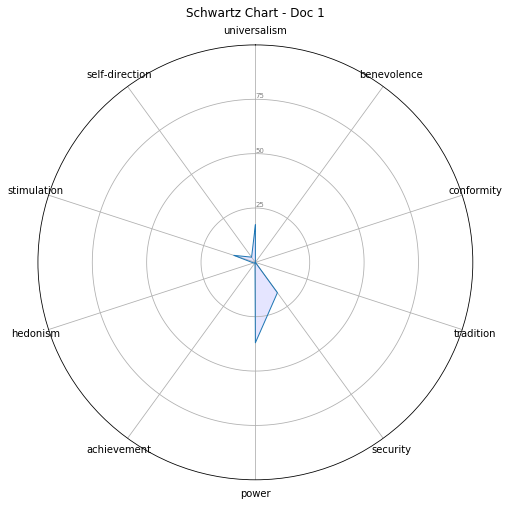

In [18]:
plot_radar_chart(W_test_norm, 1)

In [56]:
df = export_to_excel(W_test_norm, filepath = 'output.xlsx')
df.head()

,universalism,hedonism,achievement,power,self-direction,benevolence,conformity,tradition,stimulation,security,general
0,3.723499,8.970075,2.232462,5.084692,0.287173,18.209792,30.138367,7.201593,2.036556,10.510031,11.605760
1,17.170267,0.910472,0.291426,36.990267,2.961436,0.000028,0.000025,0.000022,10.429759,17.247195,13.999103


In [57]:
df = export_to_csv(W_test_norm, filepath = 'output.csv')
df.head()

,universalism,hedonism,achievement,power,self-direction,benevolence,conformity,tradition,stimulation,security,general
0,3.723499,8.970075,2.232462,5.084692,0.287173,18.209792,30.138367,7.201593,2.036556,10.510031,11.605760
1,17.170267,0.910472,0.291426,36.990267,2.961436,0.000028,0.000025,0.000022,10.429759,17.247195,13.999103
